# Lindas Lustfyllda Maskininlärning: Sjuknissarna AB - Hjärtsjukdomar
Denna jupyter notebook innehåller en analys av datan i heart.csv och en efterföljande prediktionsmodell där målet är att ha lågt antal falska negativa klassificeringar.

#### Importerar bibliotek

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split

#### Laddar datan

In [2]:
heart_data = pd.read_csv('heart.csv')

## Analys av data
Till att börja med kan vi fastställa att vi har 1025 datapunkter att arbeta med och att ingen av dem saknar värde för något attribut.

In [3]:
display(f'rows: {heart_data.__len__()}')

'rows: 1025'

In [4]:
display(f'NaN values present: {heart_data.isnull().values.any()}')

'NaN values present: False'

In [5]:
display(heart_data.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [6]:
display(heart_data.describe())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


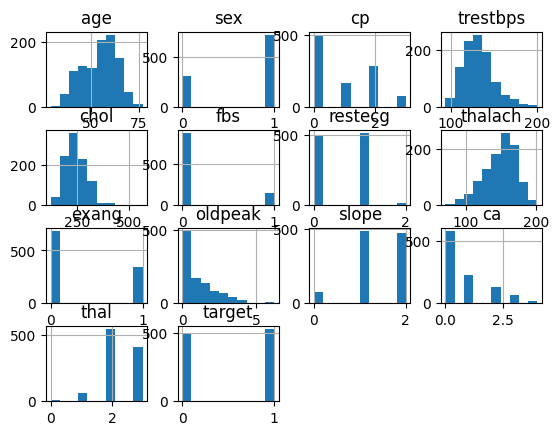

In [7]:
hist = heart_data.hist()

#### Ritar ut transformerad data i 3D
När vi ritar ut en skuggbild av datan i tre dimensioner kan vi se att det verkar finnas vissa punkter som kan bestå av extremvärden som vi kan eliminera.

In [8]:
def pca_transformation(df: pd.DataFrame, n_components: int = 3):
    pca = PCA(n_components = n_components)
    principal_components = pca.fit_transform(df)
    principal_df = pd.DataFrame(data = principal_components,
                                columns = [f'principal component {n + 1}' for n in range(n_components)],
                                index = df.index
                                )
    return principal_df

def plot_3d(df: pd.DataFrame, target_col: str = None):
    if target_col:
        targets = df[target_col]
        df = df.drop(target_col, axis = 1)
    
    if len(df.columns) > 3:
        df = pca_transformation(df)
    
    if target_col:
        data = []
        for target in targets.unique():
            rows: pd.DataFrame = df.loc[targets == target]
            data.append(go.Scatter3d(x = rows.iloc[:, 0],
                                     y = rows.iloc[:, 1],
                                     z = rows.iloc[:, 2],
                                     mode='markers',
                                     marker = dict(size = 5)
                                     )
                        )
    else:
        data = go.Scatter3d(x = df.iloc[:, 0],
                            y = df.iloc[:, 1],
                            z = df.iloc[:, 2],
                            mode='markers',
                            marker = dict(size = 5)
                            )
    fig = go.Figure(data = data)
    fig.show()

In [9]:
plot_3d(heart_data, 'target')

#### Eliminerar extremvärden
Vi tappar 56 rader, vilket verkar överkommligt.

In [10]:
heart2 = heart_data[(np.abs(stats.zscore(heart_data)) < 3).all(axis = 1)]
display(f'heart_data rows: {heart_data.__len__()}',
        f'heart2 rows: {heart2.__len__()}',
        f'rows lost: {heart_data.__len__() - heart2.__len__()}')

'heart_data rows: 1025'

'heart2 rows: 969'

'rows lost: 56'

#### Separerar klasskolumn (y2) från resterande data (X2)

In [11]:
X2 = heart2.drop('target', axis=1)
y2 = heart2['target']

#### Ritar ut transformerad data i 3D
Vår skuggbild har nu fått en annan form. Beroende på vilket typ av modell vi vill använda kan vi behöva normalisera datan.

In [12]:
plot_3d(heart2, 'target')

## Modellering: RandomForest
Vi börjar med att bygga en klass som kan hålla reda på alla variabler för modellen.

In [13]:
class ForestWrap:
    def __init__(self,
                 df: pd.DataFrame,
                 target_col: str,
                 test_size: float = 0.3,
                 n_estimators: int = 100,
                 criterion: str = 'gini',
                 max_depth: int = None,
                 min_samples_split: int|float = 2,
                 min_samples_leaf: int|float = 1,
                 max_leaf_nodes: int = None,
                 random_state: int = 309
                 ) -> None:
        self.df = df
        self.X = df.drop(target_col, axis=1)
        self.y = df[target_col]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,
                                                                                self.y,
                                                                                test_size = test_size,
                                                                                random_state = random_state
                                                                                )

        self.clf = RandomForestClassifier(n_estimators = n_estimators,
                                          criterion = criterion,
                                          max_depth = max_depth,
                                          min_samples_split = min_samples_split,
                                          min_samples_leaf = min_samples_leaf,
                                          max_leaf_nodes = max_leaf_nodes,
                                          random_state = random_state
                                          )
        self.clf.fit(self.X_train, self.y_train)

        self.y_pred = self.clf.predict(self.X_test)
        self.cv_results = cross_validate(self.clf, self.X, self.y)
        self.feature_importance = pd.DataFrame(self.clf.feature_importances_.reshape(1, self.clf.n_features_in_),
                                               columns = self.clf.feature_names_in_
                                               )

    def predict(self, X: pd.DataFrame):
        return self.clf.predict(X)

    def score(self, X: pd.DataFrame, y: pd.Series) -> float:
         return self.clf.score(X, y)
    
    def cv_scores(self):
        return self.cv_results['test_score']

    def display_confusion(self, y_true, y_pred):
        c_matrix = confusion_matrix(y_true, y_pred)
        fig = px.imshow(c_matrix,
                        text_auto = True,
                        labels = dict(x = 'Predicted',
                                      y = 'True'))
        fig.show()


#### Lastar in datan i modellen

In [14]:
model_forest = ForestWrap(df = heart2, target_col = 'target')

#### Läser ut resultaten
Vi har fått en modell som har hög träffsäkerhet (0.976 - 1) och inte ser ut att ge några falska negativa diagnoser.

In [15]:
display('test score: {:.3f}'.format(model_forest.score(model_forest.X_test, model_forest.y_test)))
for score in model_forest.cv_scores():
    display('cv score: {:.3f}'.format(score))
model_forest.display_confusion(model_forest.y_test, model_forest.y_pred)

'test score: 0.976'

'cv score: 1.000'

'cv score: 1.000'

'cv score: 0.985'

'cv score: 1.000'

'cv score: 0.984'

#### Testar diagnotisera hela datan

In [16]:
def predict(model: ForestWrap, df: pd.DataFrame, target_col: str):
    X = df.drop(target_col, axis = 1)
    y_true = df[target_col]
    y_pred = model.predict(X)
    display('accuracy score: {:.3f}'.format(model.score(X, y_true)))
    model.display_confusion(y_true, y_pred)

In [17]:
predict(model_forest, heart_data, 'target')

'accuracy score: 0.976'